# Black Box Attacks

This notebook provides a beginner friendly introduction to using adversarial black-box attacks on image classification as part of Test & Evaluation of a small dataset (xView) based on overhead imagery. In contrast to white-box attacks that rely on gradients, black-box attacks approximate the needed gradients based on the output of the model. We apply HopSkipJump, that does not rely on computing the gradients of the model. As a more practical variant, we show how to use another black-box attack, the laser beam attack. The changes introduced are here in the shape of a laser beam. To conclude the notebook, we will show how to calculate clean and attack accuracy. Computing the performance under attack is a crucial step in T&E. 

__Intended Audience__: All T&E users 

__Requirements__: Basic Python and Torchvision / ML skills. 

__Time Required__: Full run of the notebook: <20 minutes

### Contents
1. Imports and set-up
2. Load Drone data and model for classification
3. Black Box or HopSkipJump Attack
4. Practical black-box Laserbeam attack
5. Targeted Black-box attack
6. Conclusion 
7. Next steps

### Take-aways 
- How to define a custom model and a drone imagery dataset
- How black-box attacks (HopSkipJump, Laser Beam attack) work

## 1. Imports and Set-up

We import all necessary libraries for this tutorial. In this order, we first import general libraries such as numpy, then load relevant methods from ART. We then load the corresponding HEART functionality and specific torch functions to support the model. Lastly, we use a command to plot within the notebook.

In [2]:
import numpy as np
import os
import torch
from datasets import load_dataset
import matplotlib.pyplot as plt

#ART imports
from art.attacks.evasion.hop_skip_jump import HopSkipJump

#HEART imports
from heart_library.estimators.classification.pytorch import JaticPyTorchClassifier
from heart_library.metrics import AccuracyPerturbationMetric
from heart_library.attacks.evasion import HeartLaserBeamAttack
from heart_library.attacks.attack import JaticAttack

#torchvision imports
import torchvision
from torchvision import transforms

%matplotlib inline

## 2. Load Drone data and model for classification

We load the data, importing only a small part to save compute for this small demonstration. We then define the model and wrap it as JATIC pytorch classifier.

The data can be replaced as desired by the user - we first define the six labels, specify the subset used in this notebook (10 images), specify a consistent size and upscale the data to 224 x 224 pixels and then wrap everything as a modified dataframe.

Resolving data files:   0%|          | 0/31 [00:00<?, ?it/s]

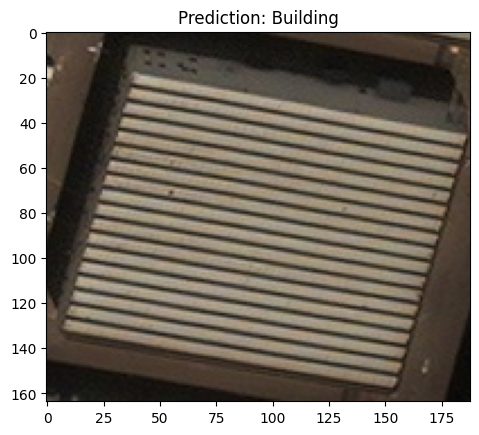

In [3]:
classes = {
    0:'Building',
    1:'Construction Site',
    2:'Engineering Vehicle',
    3:'Fishing Vessel',
    4:'Oil Tanker',
    5:'Vehicle Lot'
}

data = load_dataset("CDAO/xview-subset-classification", split="test[0:15]")
idx = 3
plt.title(f"Prediction: {classes[data[idx]['label']]}")
plt.imshow(data[idx]['image'])

'''
Transform dataset
'''
IMAGE_H, IMAGE_W = 224, 224

preprocess = transforms.Compose([
    transforms.Resize((IMAGE_H, IMAGE_W)),
    transforms.ToTensor()
])
dataT = data.map(lambda x: {"image": preprocess(x["image"]), "label": x["label"]})
to_image = lambda x: transforms.ToPILImage()(torch.Tensor(x))

sample_data = torch.utils.data.Subset(dataT, range(10))

We then load a custom model which comes with the repository. Most important is that the model has the correct input shape and is trained to perform decently well on the data. At the bottom, we wrap the model into ```JaticPyTorchClassifier```.

/root/miniforge3/envs/heart-env/lib/python3.11/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/root/miniforge3/envs/heart-env/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


/root/miniforge3/envs/heart-env/lib/python3.11/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


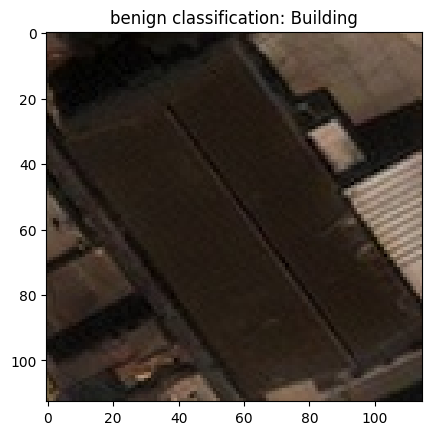

In [4]:
model = torchvision.models.resnet18(False)
num_ftrs = model.fc.in_features 
model.fc = torch.nn.Linear(num_ftrs, len(classes.keys())) 
model.load_state_dict(torch.load('../../../utils/resources/models/xview_model.pt'))
#_ = model.eval()

'''
Wrap the model
'''
jptc = JaticPyTorchClassifier(
    model=model, loss = torch.nn.CrossEntropyLoss(), input_shape=(3, 224, 224),
    nb_classes=len(classes), clip_values=(0, 1)
)

#plot original image
pred_batch = jptc(sample_data)
plt.imshow(data[1]['image'])
_ = plt.title(f'benign classification: {classes[np.argmax(np.stack(pred_batch[1]))]}')
plt.show()

# 3. Black Box or HopSkipJump Attack

White-box attacks rely on gradient information from the model. It may be desired from a more practical perspective that model internals are not known to the attacker. We thus run an additional attack that computes the perturbation purely on the output, not on the model's gradients. As before, we define the attack, run it, and plot the results with the classification outputs for inspection.

When rerunning this notebook, this part can be counted as completed if a correctly classified sample is misclassified.

HopSkipJump:   0%|          | 0/10 [00:00<?, ?it/s]

init adv example is not found, returning original image
init adv example is not found, returning original image
init adv example is not found, returning original image
init adv example is not found, returning original image
init adv example is not found, returning original image
init adv example is not found, returning original image
init adv example is not found, returning original image
init adv example is not found, returning original image


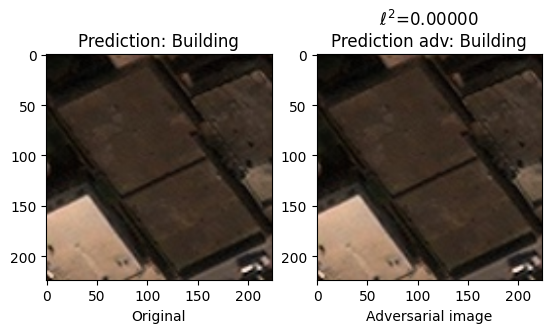

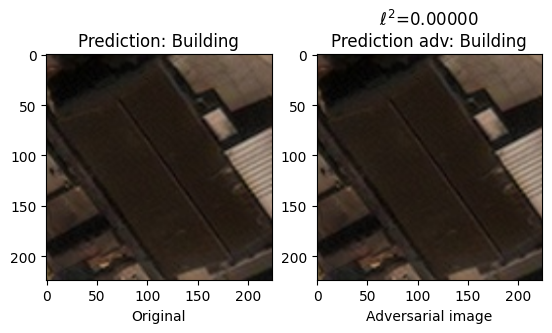

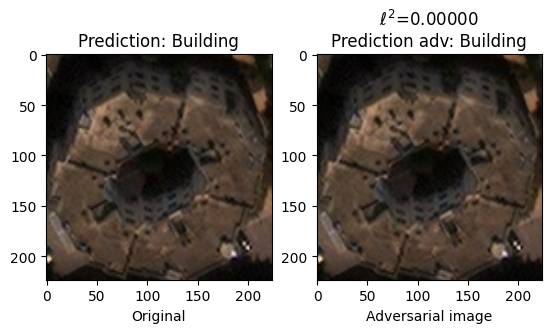

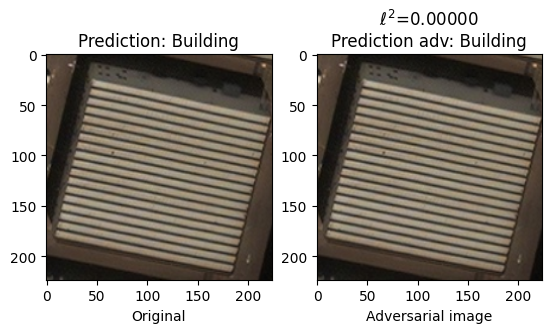

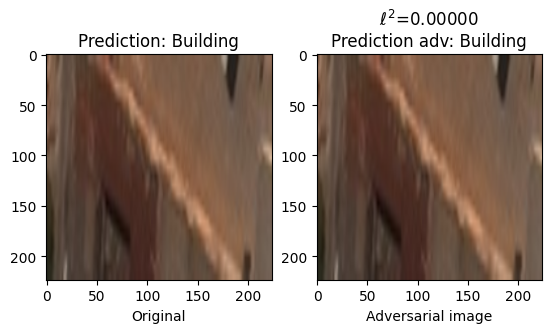

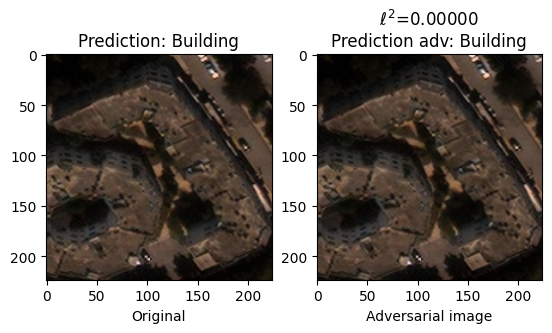

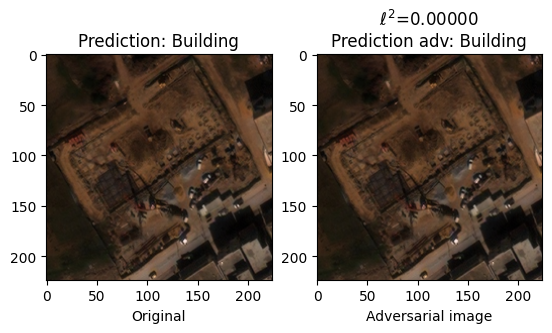

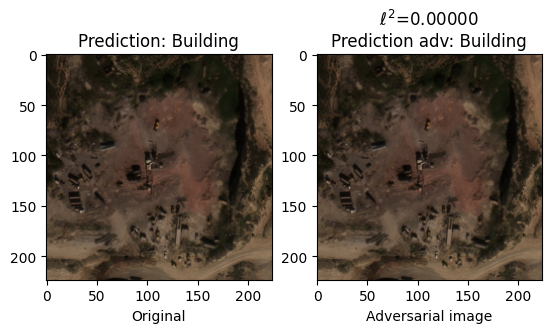

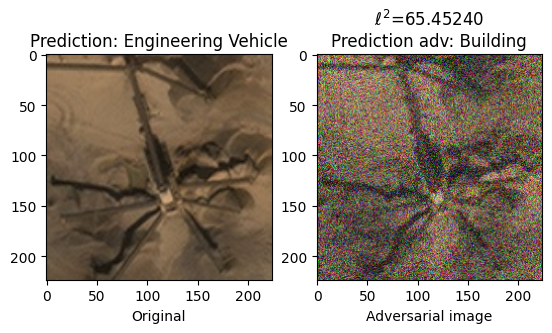

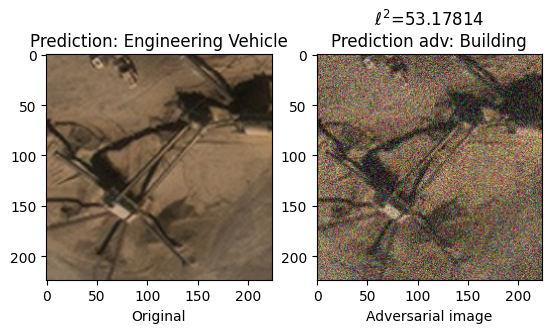

In [4]:
#defining and running attack
evasion_attack = HopSkipJump(classifier=jptc, max_iter=100, max_eval=100, init_eval=1, init_size=1, verbose=True, targeted=False)
attack = JaticAttack(evasion_attack)

x_adv, y, metadata = attack(data=sample_data, norm=2)

#visualization
preds = np.stack(jptc(sample_data))
pred_adv = np.stack(jptc(x_adv))

for i in range(10):
    f, ax = plt.subplots(1,2)
    norm_orig_img = np.asarray(sample_data[i]['image'])
    perturbation = np.linalg.norm(norm_orig_img - x_adv[i])

    ax[0].set_title(f'Prediction: {classes[np.argmax(preds[i])]}')
    ax[0].imshow(np.array(sample_data[i]['image']).transpose(1,2,0))
    ax[0].set_xlabel('Original')


    ax[1].set_title(f'$\\ell ^{2}$={perturbation:.5f}\nPrediction adv: {classes[np.argmax(pred_adv[i])]}')
    ax[1].imshow(x_adv[i].transpose(1,2,0))
    ax[1].set_xlabel('Adversarial image')
    plt.show()

## 4. Practical black-box Laserbeam attack

However, the previous black box attack applied, analogous to PGD, changes to the entire image. We thus finally consider a black box attack that applies perturbations in the form of laser beams. As before, we define the attack, compute the accuracy decrease (this time on a batch), and plot the resulting adversarial examples for inspection.

When rerunning this notebook, this part can be counted as completed if a correctly classified sample is misclassified.

In [5]:
#define attack 
laser_attack = HeartLaserBeamAttack(jptc, 5, max_laser_beam=(780, 3.14, 32, 32), random_initializations=10)

attack = JaticAttack(laser_attack, norm=2)

#Generate adversarial images
x_adv, y, metadata = attack(data=sample_data)

#Calc clean and robust accuracy
metric = AccuracyPerturbationMetric(jptc(sample_data), metadata)
metric.update(jptc(x_adv), y)
print(metric.compute())

Couldn't find adversarial laser parameters
Couldn't find adversarial laser parameters
Couldn't find adversarial laser parameters
Couldn't find adversarial laser parameters
Couldn't find adversarial laser parameters


{'clean_accuracy': 0.8, 'robust_accuracy': 0.5, 'mean_delta': 28.528248}


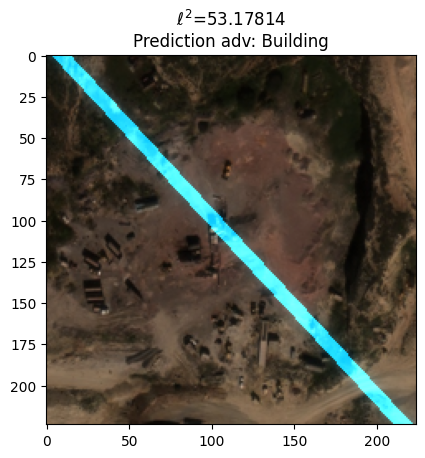

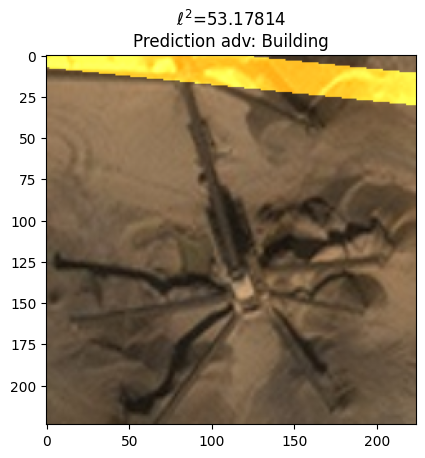

In [6]:
#Visualize the results
for img in x_adv[7:9]:
    plt.title(f'$\\ell ^{2}$={perturbation:.5f}\nPrediction adv: {classes[np.argmax(pred_adv[i])]}')
    plt.imshow(img.transpose(1,2,0))
    plt.show()

# 5. Targeted black-box attack

The following cells demonstrate execution of a targeted _HopSkipJump_ attack against the model. Unlike an untargeted black-box attack, in this scenario an adversary is attempting to elicit a specific incorrect classification from the model. For instance, the following example demonstrates how an attack might trick a classifier to misclassify an engineering vehicle as a building. In order to achieve this, we simply provide an incorrect _target_ label in the dataset we pass to the attack augmentation and set the _targeted_ parameter to be _True_. 

It can sometimes be easier to successfully attack a model using a targeted attack as, with a well defined objective, the attack may converge quicker (and with few necessary iterations).


Here we set the target label to be _0_ in all instances of our sample data. An index of _0_ corresponds to the class "Building".

In [5]:
class TargetedImageDataset:
    
    def __init__(self, images):
        self.images = images
    def __len__(self)->int:
        return len(self.images)
    def __getitem__(self, ind: int):
        image = np.asarray(self.images[ind]['image'])
        y = np.zeros(len(classes))
        y[0] = 1
        return image, y, {}

targeted_sample_data = TargetedImageDataset(sample_data)

The only other step is to add the _targeted_ parameter and set it to _True_. This tells the _HopSkipJump_ algorithm to minimize the loss between the models prediction and the provided target label, in this case "Building".

HopSkipJump:   0%|          | 0/10 [00:00<?, ?it/s]

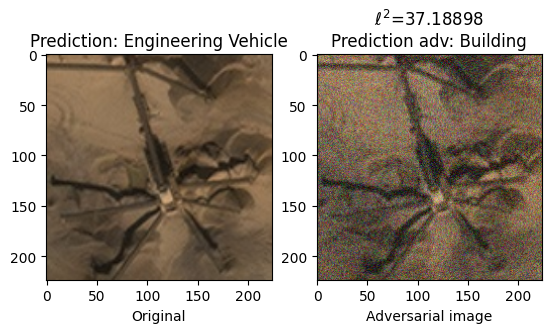

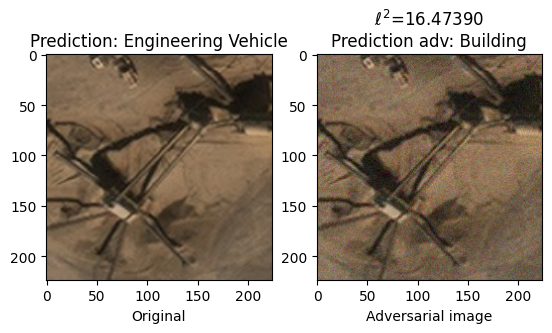

In [6]:
#defining and running attack
evasion_attack = HopSkipJump(classifier=jptc,
                                  verbose=True,
                                  targeted=True,
                                  init_size=100,
                                  max_eval=100,
                                  init_eval=100,
                                  max_iter=50)
attack = JaticAttack(evasion_attack)

x_adv, y, metadata = attack(data=targeted_sample_data, norm=2)

#visualization
preds = np.stack(jptc(sample_data))
pred_adv = np.stack(jptc(x_adv))

for i in range(8,10):
    f, ax = plt.subplots(1,2)
    norm_orig_img = np.asarray(sample_data[i]['image'])
    perturbation = np.linalg.norm(norm_orig_img - x_adv[i])

    ax[0].set_title(f'Prediction: {classes[np.argmax(preds[i])]}')
    ax[0].imshow(np.array(sample_data[i]['image']).transpose(1,2,0))
    ax[0].set_xlabel('Original')


    ax[1].set_title(f'$\\ell ^{2}$={perturbation:.5f}\nPrediction adv: {classes[np.argmax(pred_adv[i])]}')
    ax[1].imshow(x_adv[i].transpose(1,2,0))
    ax[1].set_xlabel('Adversarial image')
    plt.show()

## 6. Conclusion
We have successfully attacked a model with adversarial example that are based only on the model's in/output. In the next steps, we can test several attacks at once on a model or we can attempt to defend the computed examples.

## 7. Next steps
- [3. How to Simulate Auto Attack for Image Classification](https://github.com/IBM/heart-library/tree/main/notebooks/how_tos/image_classification/3_How_to_Simulate_Auto_Attack_for_Image_Classification.ipynb)
- [4. How to Create Defenses for Image Classification](https://github.com/IBM/heart-library/tree/main/notebooks/how_tos/image_classification/4_How_to_Create_Defenses_for_Image_Classification.ipynb)
- [5. How to Replace Datasets in Model Evaluation](https://github.com/IBM/heart-library/tree/main/notebooks/how_tos/image_classification/5_How_to_Replace_Datasets_in_Model_Evaluation.ipynb)